In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

np.random.seed(1)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [6]:
df_ = pd.read_csv('../Datasets/AirlineTweets.csv')

In [8]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [10]:
df = df_[['airline_sentiment', 'text']].copy()

In [12]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

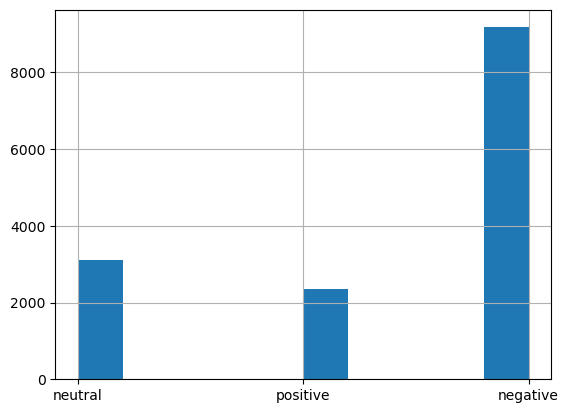

In [14]:
df['airline_sentiment'].hist()

In [16]:
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)

In [18]:
df.head()

,airline_sentiment,text,target
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


In [24]:
df_train, df_test = train_test_split(df, stratify = df['target'])

In [26]:
df_train.head()

,airline_sentiment,text,target
10047,negative,@USAirways Round Two of being THE worst airlin...,0
14121,neutral,@AmericanAir you wont allow calls? My husband ...,2
13970,neutral,@AmericanAir its Adolfo Garcia,2
10153,negative,@USAirways u guys suck,0
938,negative,@SouthwestAir doesn't charge ticket change fee...,0


In [28]:
vectorizer = TfidfVectorizer(max_features=2000)
X_train = vectorizer.fit_transform(df_train['text'])
X_train

<10980x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 158601 stored elements in Compressed Sparse Row format>

In [30]:
X_test = vectorizer.transform(df_test['text'])

In [32]:
Y_train = df_train['target']
Y_test = df_test['target']

In [38]:
model = LogisticRegression(max_iter=500, class_weight = 'balanced')
model.fit(X_train, Y_train)
print("Train acc:", model.score(X_train, Y_train))
print("Test acc:", model.score(X_test, Y_test))

Train acc: 0.8395264116575591
Test acc: 0.7702185792349727


In [40]:
Pr_train = model.predict_proba(X_train)#[:, 1]
Pr_test = model.predict_proba(X_test)#[:, 1]
print("Train AUC:", roc_auc_score(Y_train, Pr_train, multi_class='ovo'))
print("Test AUC:", roc_auc_score(Y_test, Pr_test, multi_class='ovo'))

Train AUC: 0.9541542536902274
Test AUC: 0.8973244592649084


In [44]:
P_train = model.predict(X_train)
P_test = model.predict(X_test)

In [46]:
cm = confusion_matrix(Y_train, P_train, normalize='true')
cm

array([[0.83628704, 0.04590354, 0.11780941],
       [0.04571106, 0.8758465 , 0.07844244],
       [0.10671256, 0.07185886, 0.82142857]])

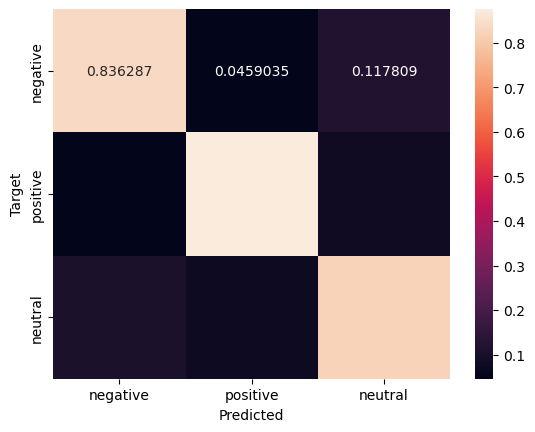

In [48]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  classes = ['negative', 'positive', 'neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

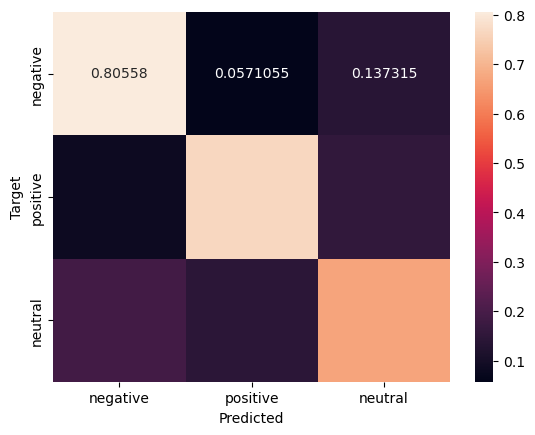

In [50]:
cm_test = confusion_matrix(Y_test, P_test, normalize='true')
plot_cm(cm_test)

## Binary Labels & Model Interpretation

In [53]:
binary_target_list = [target_map['positive'], target_map['negative']]
df_b_train = df_train[df_train['target'].isin(binary_target_list)]
df_b_test = df_test[df_test['target'].isin(binary_target_list)]

In [55]:
df_b_train.head()

,airline_sentiment,text,target
10047,negative,@USAirways Round Two of being THE worst airlin...,0
10153,negative,@USAirways u guys suck,0
938,negative,@SouthwestAir doesn't charge ticket change fee...,0
4649,negative,@SouthwestAir why do you let one person board ...,0
3396,positive,@united Thank you for responding so promptly! ...,1


In [57]:
X_train = vectorizer.fit_transform(df_b_train['text'])
X_test = vectorizer.transform(df_b_test['text'])

In [59]:
Y_train = df_b_train['target']
Y_test = df_b_test['target']

In [61]:
model = LogisticRegression(max_iter=500, class_weight = 'balanced')
model.fit(X_train, Y_train)
print("Train acc:", model.score(X_train, Y_train))
print("Test acc:", model.score(X_test, Y_test))

Train acc: 0.9353049907578558
Test acc: 0.9074523396880416


In [63]:
Pr_train = model.predict_proba(X_train)[:, 1]
Pr_test = model.predict_proba(X_test)[:, 1]
print("Train AUC:", roc_auc_score(Y_train, Pr_train))
print("Test AUC:", roc_auc_score(Y_test, Pr_test))

Train AUC: 0.982246471026478
Test AUC: 0.9577799512300904


In [65]:
model.coef_

array([[-0.36642429,  0.80742045, -0.53960007, ...,  0.05888811,
         0.15250612, -0.23340481]])

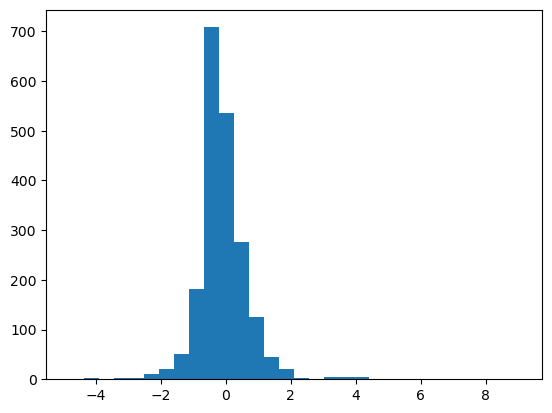

In [67]:
plt.hist(model.coef_[0], bins=30);

In [70]:
word_index_map = vectorizer.vocabulary_
word_index_map

{'usairways': 1869,
 'round': 1506,
 'two': 1827,
 'of': 1248,
 'being': 245,
 'the': 1737,
 'worst': 1973,
 'airline': 116,
 'ever': 639,
 'guys': 837,
 'suck': 1683,
 'southwestair': 1638,
 'doesn': 568,
 'charge': 349,
 'ticket': 1761,
 'change': 344,
 'fees': 699,
 'do': 566,
 'they': 1743,
 'not': 1231,
 'same': 1527,
 'costs': 446,
 'that': 1735,
 'you': 1995,
 'united': 1850,
 'why': 1943,
 'let': 1042,
 'one': 1266,
 'person': 1329,
 'board': 264,
 'with': 1952,
 'early': 596,
 'bird': 255,
 'and': 145,
 'save': 1532,
 'seats': 1546,
 'for': 759,
 'entire': 626,
 'party': 1309,
 'notcool': 1233,
 'thank': 1732,
 'responding': 1487,
 'so': 1619,
 'look': 1080,
 'forward': 767,
 'to': 1772,
 'drive': 585,
 'office': 1254,
 'file': 708,
 'claim': 368,
 'jetblue': 986,
 'min': 1162,
 'response': 1488,
 'time': 1766,
 'impressed': 942,
 'in': 944,
 'it': 977,
 'trueblue': 1811,
 'gets': 807,
 'social': 1620,
 'god': 817,
 'damn': 488,
 'fucking': 788,
 'crew': 466,
 'won': 1956,
 'b

In [72]:
# let's look at the weights for each word
# try it with different threshold values!
threshold = 2

print("Most positive words:")
for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight > threshold:
        print(word, weight)

Most positive words:
southwestair 3.6435156511576245
thank 8.503471832145172
jetblue 3.5925030849670567
virginamerica 3.5772846845618353
thanks 9.052727615373836
kudos 3.455362739175426
good 3.5837138632603884
great 5.520129425077889
love 4.019209001749678
amazing 3.9908602573898655
appreciate 3.0720024745110996
made 2.092530432241082
nice 2.0170511795174106
awesome 4.228118868869242
thx 3.2898102899655903
helpful 2.049140416463735
best 4.116951414463173
cool 2.3753764017098877
worries 3.4343413029925762
wonderful 2.416814376260291
excellent 2.050936431269976


In [74]:
print("Most negative words:")
for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight < -threshold:
        print(word, weight)

Most negative words:
worst -3.9037287314002302
not -4.818546755222688
why -2.4962202831003943
hour -2.936662478978908
delayed -3.2287230941910052
bag -2.1965523564205722
no -4.017796430304632
cancelled -2.72479766336084
what -2.1145525282067643
rude -2.3852768670929705
hold -3.3109868270782488
call -2.456745632957343
again -2.1009615500051675
hours -3.6955287412546065
nothing -2.4109540373698852
delay -2.34563094466982
stuck -2.149674131987481
told -2.365892534860641
need -2.033101607084435
disappointed -2.0165196262396314
paid -2.0118427726506636
